## PhotDM Reference Implementation

This notebook should how model annotations can be used to plot SEDs from a VOTable.

The annotation bind the data cells with the description of their Photometric calibration.
- Some brighness are given as magnitudes and some others as fluxes.
- The photometric calibrations are given as instances of PhotDM.
- The challenge of that code is to build SEDs (wavelength vs fluxes) just by using these annotations. 
  - There no use of any data not within the VOTable
  - All data access are done through the model view of each data row.

#### Input Data

The input VOTable (NWAYAWGXMM.xml) provided by HEASARC is a subset of the XMMSL2 catalogue.
Let's consider the quantities of interest :
- Each XMMSL2 source comes with a name, a position and fluxes in EB6,7,8 bands
- For each XMMSL2 sources, we get the following counterpart magnitudes:
  - Wise W1,2,3,4
  - 2MASS Ks,H,J
  - GAIA G
The others columns are ignored by this proof of concept.

#### Annotation Model

The goal of this exercice is to validate PhotDM.
To make this example working, we need a model that encompasses the photometric calibrations with the brightness data.
For this purpose, we have built a mock model named `sed`.
- A sed is
  - A name
  - a position
  - a collection a photometric points which are
    - A magnitude or a flux
    - A pointer to the PhotCal instance
    
#### The code
The code iterates over the data table and build an `sed` instance for each row. 
- Magnitudes are converted into fluxes and the SED is then plotted.

The code is based on XPATH queries
- The model viewer returns an XML view on the mapped row (and SED instance)
- The client code runs XPATH queries on that XML view to retrieve data

Photometric calibration are handled by instances of a package class (`PhotCal`) that wrapps XPATH queries into Pytho getters. 

#### Watchout: X-Ray Photcal
In this data set, we assimilate the X-Ray energy bands to photometric calibrations without zero point and with a square filter profile.
This approach is questionnable, but it is workable in this example.

LM 28/02/2022

In [11]:
import os, sys
import numpy as np
import logging
import matplotlib
import mplcursors
import matplotlib.pyplot as plt 
from astropy.io.votable import parse
from astropy import units as u

base_dir = os.path.realpath(os.path.join(os.getcwd(), ".."))
data_dir = os.path.join(base_dir, "mivot_code", "examples", "data/")

print(os.getcwd())
print(base_dir)
print(data_dir)

sys.path.append(os.path.realpath(base_dir))
                             
from mivot_code.client.class_wrappers.photdm.photcal import PhotCal
from mivot_code.client.xml_interpreter.model_viewer import ModelViewer

matplotlib.font_manager: logging.getLogger('matplotlib.font_manager').setLevel(logging.WARNING)
matplotlib.font_manager: logging.getLogger('matplotlib.ticker').setLevel(logging.WARNING)
%matplotlib widget

/Users/laurentmichel/Documents/seafile/Seafile/workspaces/git/modelinstanceinvot-code/mivot_code/client/xml_interpreter
/Users/laurentmichel/Documents/seafile/Seafile/workspaces/git/modelinstanceinvot-code/mivot_code/client
/Users/laurentmichel/Documents/seafile/Seafile/workspaces/git/modelinstanceinvot-code/mivot_code/client/mivot_code/examples/data/
  DEBUG - [pyplot.py:280 - switch_backend()] - Loaded backend module://ipympl.backend_nbagg version unknown.


Build the model viewer that will be used to explore the data set

In [12]:
votable = parse(os.path.join(data_dir, "NWAYAWGXMM.xml"))
counter = 0
for resource in votable.resources:
    mviewer = ModelViewer(resource, votable_path=os.path.join(data_dir, "NWAYAWGXMM.xml"))
    break;

FileNotFoundError: [Errno 2] No such file or directory: '/Users/laurentmichel/Documents/seafile/Seafile/workspaces/git/modelinstanceinvot-code/mivot_code/client/mivot_code/examples/data/NWAYAWGXMM.xml'

### Main loop
For each row,
- get the model view
- for each point in the row
  - build the PhotCal instances
  - convert the magnitudes into fluxes
  - plot the SED

Run the cell again to get the next source...

  DEBUG - [model_viewer.py:203 - connect_table()] - table None found in VOTable
  DEBUG - [model_viewer.py:208 - connect_table()] - TEMPLATES None found 
XMMSL2/XMMSL2.EB6 1.1 keV 1.17e-12  erg/s/cm^2
XMMSL2/XMMSL2.EB8 6.1 keV 2.744e-12  erg/s/cm^2
WISE/WISE.W1/Vega 33526.0 Angstrom 5.197036183152993e-10  erg/s/cm^2
WISE/WISE.W2/Vega 46028.0 Angstrom 2.1280846246374458e-10  erg/s/cm^2
WISE/WISE.W3/Vega 115608.0 Angstrom 1.5365111894057366e-11  erg/s/cm^2
WISE/WISE.W4/Vega 220883.0 Angstrom 1.9152281109904687e-12  erg/s/cm^2
2MASS/2MASS.H/Vega 16620.0 Angstrom 3.2575391217470535e-09  erg/s/cm^2
2MASS/2MASS.J/Vega 12350.0 Angstrom 4.647742539228576e-09  erg/s/cm^2
2MASS/2MASS.Ks/Vega 21590.0 Angstrom 1.672490469813149e-09  erg/s/cm^2
GAIA/GAIA2.G/Vega 6230.0 Angstrom 6.89836775490075e-09  erg/s/cm^2


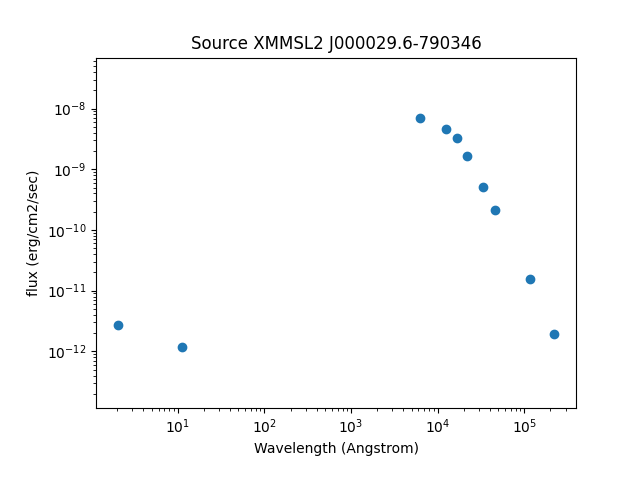

In [15]:
mviewer.connect_table(None)
times = []
ras = []
decs = []
cpt=0
while True:
    # Iterate until the next row
    for cpt in range(counter):
        row = mviewer.get_next_row() 
    if row is None:
        break  
    row_model_view = mviewer.get_model_view(resolve_ref=False)
    phot_points = mviewer.get_model_component_by_type("sed:PhotPoint")
    wl = []
    flx = []
    tlt = []
    name = None
    for ele in row_model_view.xpath('.//ATTRIBUTE[@dmrole="sed:Source.name"]'):
        name  = ele.get("value")
        break
    for phot_point in phot_points:
        #XmlUtils.pretty_print(phot_point)
        flux = None
        unit = None
        unit_org = None
        phot_cal = None
        flux_erg = None
        for ele in phot_point.xpath('.//ATTRIBUTE[@dmrole="sed:PhotPoint.flux"]'):
            try:
                flux = float(ele.get("value"))
                unit_org = ele.get("unit_org")
                unit = ele.get("unit")
            except:
                pass
            break
        for ele in phot_point.xpath('.//INSTANCE[@dmrole="sed:PhotPoint.photcal"]'):
            phot_cal = PhotCal(ele)
            spec_loc = phot_cal.photometryFilter.spectralLocation
            spec_loc_value = None
            # convert XMM energy into wavelength
            if spec_loc.unitexpression == "keV":
                spec_loc_value = (spec_loc.value * u.keV).to(u.angstrom, equivalencies=u.spectral()).value
            else: 
                spec_loc_value = spec_loc.value
            break
        if flux is not None:
            if unit_org == "mag":
                zeroPoint = phot_cal.zeroPoint.flux.value
                refMag = phot_cal.zeroPoint.referenceMagnitudeValue
                flux_erg = 1e-23 * zeroPoint * np.power( 10, - (flux - refMag)/2.5) * (299792458 / (spec_loc_value*1E-10))
            else:
                flux_erg = flux
            flx.append(flux_erg)
            wl.append(spec_loc_value)
            tlt.append(phot_cal.identifier)
            print(f"{phot_cal.identifier} {spec_loc.value} {spec_loc.unitexpression} {flux_erg}  {unit}")

    plt.clf()
    plt.scatter(wl, flx)
    plt.title("Source " + name)
    plt.xscale("log")
    # Lim must be force to work on Linux Py3.6
    plt.ylim([min(flx)/10, max(flx)*10])
    plt.yscale("log")
    plt.xlabel("Wavelength (Angstrom)")
    plt.ylabel("flux (erg/cm2/sec)")
    mplcursors.cursor(hover=True).connect("add", lambda sel: sel.annotation.set_text(tlt[sel.index]))
    plt.subplots_adjust(bottom=.15, left=.15) 
    plt.show()
    counter += 1
    break